 This notebook samples configurations for a 2-site Hexagonal Hubbard Model using HMC and constructs the fermion matrix using diagonal discretization

The hamiltonian required for 2-site Hubbard model is :
\begin{equation}
    \begin{split}
    H & = \frac{\vec{p}^2}{2} + \frac{\vec{\phi}^2}{2\tilde{U}} - \log\det \left[M[\phi,\tilde{\kappa},\tilde{\mu}]M[-\phi,-\tilde{\kappa},-\tilde{\mu}]\right] \\ & \equiv  \frac{\vec{p}^2}{2} + S_{eff}[\phi], 
    \end{split}
\end{equation}
where the effective action $S_{eff}$ comes from the Hubbard-Stratonovich transformation: 
\begin{equation}
    S_{eff}[\phi] = \frac{\vec{\phi}^2}{2\tilde{U}} - \log\det \left[M[\phi,\tilde{\kappa},\tilde{\mu}]M[-\phi,-\tilde{\kappa},-\tilde{\mu}]\right].
\end{equation}
Here the parameters of the Hubbard model, the potential energy $U$, the chemical potential $\mu$, and the hopping matrix $\kappa$ are scaled to the discretized time $\delta$:
\begin{equation}
    \delta =\frac{\beta}{N_t}, \quad \tilde{\kappa}=\delta\kappa, \quad \tilde{U}=\delta U, \quad \tilde{\mu} = \delta\mu.
\end{equation}

The elements of the fermion matrix $M[\phi,\tilde{\kappa},\tilde{\mu}]$ can be calculated by *diagonal discretization*:
\begin{equation}
    M[\phi,\tilde{\kappa},\tilde{\mu}]_{x't';xt} =(1+\tilde{\mu})\delta_{x',x}\delta_{t',t} - B_{t'}e^{i\phi_{x,t}}\delta_{x',x}\delta_{t',t+1} - h_{x',x}\delta_{t',t},
\end{equation}

with the hopping matrix $h_{x',x}=\tilde{\kappa}\delta_{\langle x',x\rangle}$, and the anti-periodic boundary condition:
\begin{equation}
    B_{t} =\begin{cases}
    +1, & 0<t<N_t \\
    -1, & t =0.
  \end{cases}
\end{equation}
    

In [1]:
#import the modules we will need
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from numba import jit
from tqdm.notebook import tqdm

In [2]:
def calcK(delta):     # calculates the exponential of Hopping matrix for diagonal discretization 
    return [[0.0,delta],[delta,0.0]]

#Constructing Fermion Matrix M[phi]
def Mphi(phi, k, nt):
    """
    Function that updates the Fermion matrix
    
    INPUT:
            phi - phi field (array)
            k - hopping parameter (array)
            nt - number of time steps
                        
    OUTPUT:
            M - fermion matrix (update M) 
            
            This uses space index fastest (like Isle)
    """
    n = len(phi)
    nx = int(n/nt)
    if n == M.shape[0]: # this tests if the phi array has the right dimensions
        for t in range(nt-1): # loop over time bloks
            for x in range(nx): # loop over cords and kappa matrix
                M[(t+1)*nx+x][t*nx+x] = -np.exp(1j*phi[t*nx+x]) # gauge on time off diagonal
                for y in range(nx):
                    M[t*nx+x][t*nx+y] = -k[x][y] + 0j # hopping term on time diagonal
                    if y==x:
                        M[t*nx+x][t*nx+y] += 1.0 + 0j  # diagonal term
        for x in range(nx): 
            M[x][(nt-1)*nx+x] = np.exp(1j*phi[(nt-1)*nx+x])  # anti-periodic BC
            for y in range(nx):
                M[(nt-1)*nx+x][(nt-1)*nx+y] = -k[x][y] + 0j # hopping term on time diagonal
                if y==x:
                    M[(nt-1)*nx+x][(nt-1)*nx+x] += 1.0+0j # diagonal term
            
        return 0
    else:
        print('# Error! phi and M have inconsistent dimensions!')
        return -1
    
    
# function to calculate log det M[phi]M[-phi]

def calcLogDetMM(phi, expk, nt):
    """
    Function that calculates the determinant of Fermion matrices
    
    INPUT:
            phi - phi field (array)
            expk - exponential of hopping parameter (array)
            Nt - number of time steps
                        
    OUTPUT:
            detMM - determinant of the matrices
    """
    
    Mphi(phi, expk, nt) # update M with +1 phi
    detMM = np.log(np.linalg.det(M)) # calc detM with +1 phi
    Mphi(-np.array(phi), expk, nt) # update M with -1 phi
    detMM += np.log(np.linalg.det(M)) # calc detM with -1 phi
    return detMM



To get the force equations, we need to calculate the following:

\begin{equation}
\partial_{\phi_{xt}}\log\det M[\phi]M[-\phi] = \operatorname{tr}\left(M^{-1}[\phi]\partial_{\phi_{xt}}M[\phi]\right)+ \operatorname{tr}\left(M^{-1}[-\phi]\partial_{\phi_{xt}}M[-\phi]\right)
\end{equation}

For this particular problem, since it is bi-partite, half-filling, and we are working in the particle/hole basis, the above equation simplifies to

\begin{equation}
\partial_{\phi_{xt}}\log\det M[\phi]M[-\phi] =2\operatorname{Re} \operatorname{tr}\left(M^{-1}[\phi]\partial_{\phi_{xt}}M[\phi]\right)
\end{equation}

The routine below calculates the following:
\begin{equation}
i \mathcal{B}_{\tau+1}\left(e^{-i \phi_{\mu \tau}} M^{-1 \dagger}[\phi,-\tilde{\kappa}]_{\mu(\tau+1), \mu \tau}-e^{i \phi_{\mu \tau}} M^{-1}[\phi, \tilde{\kappa}]_{\mu \tau, \mu(\tau+1)}\right)
\end{equation}

In [3]:
def calcTrMM(phi, k, nt, sign):  # this is for diagonal discretization
    """
    Function that calculates the trace of a Fermion matrix
    
    INPUT:
            phi - phi field (array)
            expk - exponential of hopping term (array)
            nt - number of time steps
            sign - sign of phi (+1 / -1)
                        
    OUTPUT:
            TrMM - trace of the matrix
    """
    TrMM = [] # trace container
    n = len(phi)
    nx = int(n/nt)
    Mphi(phi, k, nt) # update M
    invM = np.linalg.inv(M)  # only need to invert once!
    for t in range(nt-1): # loop over time blocks
        for x in range(nx): # loop over sites  (space is fastest)
            TrMM.append(-sign*1j*np.exp(1j*phi[t*nx+x])*invM[t*nx+x][(t+1)*nx+x])
    for x in range(nx): # anti-periodic boundry conditions
        TrMM.append(sign*1j*np.exp(1j*phi[(nt-1)*nx+x])*invM[(nt-1)*nx+x][x])

    return np.array(TrMM)


In [4]:
def artH(p, phi, expk, nt, U): 
    """
    Function that calculates the artificial Hamiltonian of the Hubbard model
    
    INPUT:
            p - conjugate momentum (array)
            phi - phi field (array)            
            expk - exponential of hopping array (array)
            Nt - number of timesteps
            U - onsite coupling (reduced quantity = U * delta)
            
            (optional)
            beta = inverse temperature
                        
    OUTPUT:
            H - artificial Hamiltonian
    """
        
    H = .5*(np.array(p)@np.array(p)+ np.array(phi)@np.array(phi)/U) 
    
    H -= np.real(calcLogDetMM(phi, expk, nt))
    return H

def gradS(phi,U,Nt):  #gradient for action
    return phi/U - 2*np.real(calcTrMM(phi,expk,Nt,1))

In [5]:
def ribbit(p, phi, expk, nt, U, Nmd, trajLength = 1.):
    """
    Molecular dynamics integrator (Leap frog algorithm)
    
    INPUT:
            p - conjugate momentum (array)
            phi - phi field (array)
            expk - exponential of hopping parameter (array)
            nt - number of timesteps
            Nmd - number of trajectory pieces
            U - onsite coupling
            
            (optional)
            trajLength - length of trajectory
            
    OUTPUT:
            (p, phi) - after integration
    """    
    # python passes variables via "pass by object"
    # need to define new arrays, otherwise the original arrays will change themselves during this call!
    p = np.array([p[i] for i in range(len(p))])
    phi = np.array([phi[i] for i in range(len(phi))])
        
    eps = trajLength/Nmd # integration step
    
    phi += 0.5*eps*p # first half step
    
    # (N - 1) steps of integration
    for _ in range(Nmd-1):
        p -= eps*gradS(phi,U,nt)  
        phi += eps*p

    # last half step
    p -= eps*gradS(phi,U,nt)      
    phi += 0.5*eps*p
    
    return p, phi



In [6]:
# initialize constants for the functions
U=2. # spin coupling
beta=4. # inverse temperature
Nt=16 # number of time steps
Nx = 2 # number of sites
delta = beta/Nt  #discretized time
usqrt = np.sqrt(delta*U) #reduced U

M = np.identity(Nt*Nx) + 0j # (Nt*Ni) x (Nt*Ni) identity matrix
expk = calcK(delta) # Use this for diagonal discretization

Nmd = 3 # 3-5 for best acceptance >= 70%
nTrajs = 10000 # number of auxiliary fields in the ensemble

prob = [] # stores probability
ensemble = []  # store the individual configurations here

# sample phi from normal distribution with sigma = sqrt(u)
phi = np.array([np.random.normal(0,usqrt) for i in range(Nt*Nx)])

# loop that generates the ensamble of phis
for traj in tqdm(range(nTrajs)):
    # sample momentum from normal distribution w/ sigma = 1
    initP = np.array([np.random.normal(0,1) for i in range(Nt*Nx)])
    
    initPhi = phi #[-Nt*Nx:] # initial Phi
    initH = artH(initP, initPhi, expk, Nt, U*delta) # initial Hamiltonian
    
    finP, finPhi = ribbit(initP, initPhi, expk, Nt, U*delta, Nmd) # final momentum and phi

    finH = artH(finP, finPhi, expk, Nt, U*delta) # final hamiltonian
    
    # accept/reject step
    if np.random.uniform(0,1) <= np.exp(-(finH-initH)): # accept
        phi = finPhi
        ensemble.append(phi)
        prob.append(1.)
    else: # reject
        ensemble.append(phi)
        prob.append(0.)
        
prob = np.array(prob)
print("Acceptance probability=",np.mean(prob))

  0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance probability= 0.7308


In [7]:
# Results from Exact diagonalization

exactData = open("U2B4.dat").readlines()
exT = []
exBonding = []
exAntiBonding = []
exAA = []
exAB = []
exBA = []
exBB = []
for i in range(len(exactData)):
    split = exactData[i].split()
    exT.append(float(split[0]))   # tau
    exAntiBonding.append(float(split[1]))  # anti-bonding
    exBonding.append(float(split[2]))      # bonding
    exAA.append(float(split[3]))  # cAA
    exAB.append(float(split[4]))  # cAB
    exBA.append(float(split[5]))  # cBA
    exBB.append(float(split[6]))  # cBB

<Figure size 432x288 with 0 Axes>

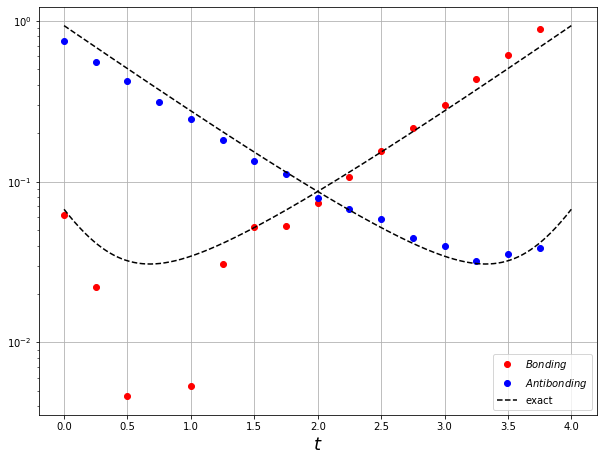

In [8]:
corrUp_b = [ [] for t in range(Nt)] # <===== each correlator has Nt elements
corrUp_ab = [ [] for t in range(Nt)]
Cxx = [ [] for t in range(Nt)]
Cxy = [ [] for t in range(Nt)]
Cyx = [ [] for t in range(Nt)]
Cyy = [ [] for t in range(Nt)]

nTherm = 200

### calculate the bonding/anti-bonding correlator
for i in range(nTherm,nTrajs):
    # arrow up correlator
    phi = ensemble[i]
    Mphi(phi,expk,Nt)
    invMUp = np.linalg.inv(M)
    
    # we now construct the correlators
    # bonding correlator is .5*(Cxx+Cxy+Cyx+Cyy)
    # antibonding is .5*(Cxx-Cxy-Cyx+Cyy)
    for t in range(Nt):
        corrUp_b[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]+invMUp[t*Nx+0][0*Nx+1]+
                               invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
        corrUp_ab[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]-invMUp[t*Nx+0][0*Nx+1]-
                               invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
        Cxx[t].append(np.real(invMUp[t*Nx+0][0*Nx+0]))
        Cxy[t].append(np.real(invMUp[t*Nx+0][0*Nx+1]))
        Cyx[t].append(np.real(invMUp[t*Nx+1][0*Nx+0]))
        Cyy[t].append(np.real(invMUp[t*Nx+1][0*Nx+1]))

# here I set up arrays that store the averages
corrBond = []
corrAntiBond = []

# ok, I'm mixing up naming conventions.  Here 'A' = 'x' and 'B' = 'y'
cAA = []
cAB = []
cBA = []
cBB = []

# now I calculate the averages for each timeslice
for t in range(Nt):
    corrBond.append(np.mean(corrUp_b[t]))
    corrAntiBond.append(np.mean(corrUp_ab[t]))
    cAA.append(np.mean(Cxx[t]))
    cAB.append(np.mean(Cxy[t]))
    cBA.append(np.mean(Cyx[t]))
    cBB.append(np.mean(Cyy[t]))
        
tau = np.linspace(0,beta-beta/Nt,Nt) # <===== this is the correct distancing for tau

plt.suptitle('U={}, beta={}, Nt={}\nsamples={}'.format(U,beta,Nt,nTrajs),fontsize=20)

plt.subplots(1,1,figsize=(10,7.5))
plt.plot(tau,corrBond,'ro',label= r'$Bonding$')
plt.plot(tau,corrAntiBond,'bo', label = '$Antibonding$')
plt.plot(exT,exBonding,'k--',label='exact')
plt.plot(exT,exAntiBonding,'k--')
plt.grid()
plt.xlabel(r'$t$',fontsize=18)
plt.yscale('log')
plt.legend(loc='best')

Text(0.5, 0.98, 'U=2.0, beta=4.0, Nt=16\nsamples=10000')

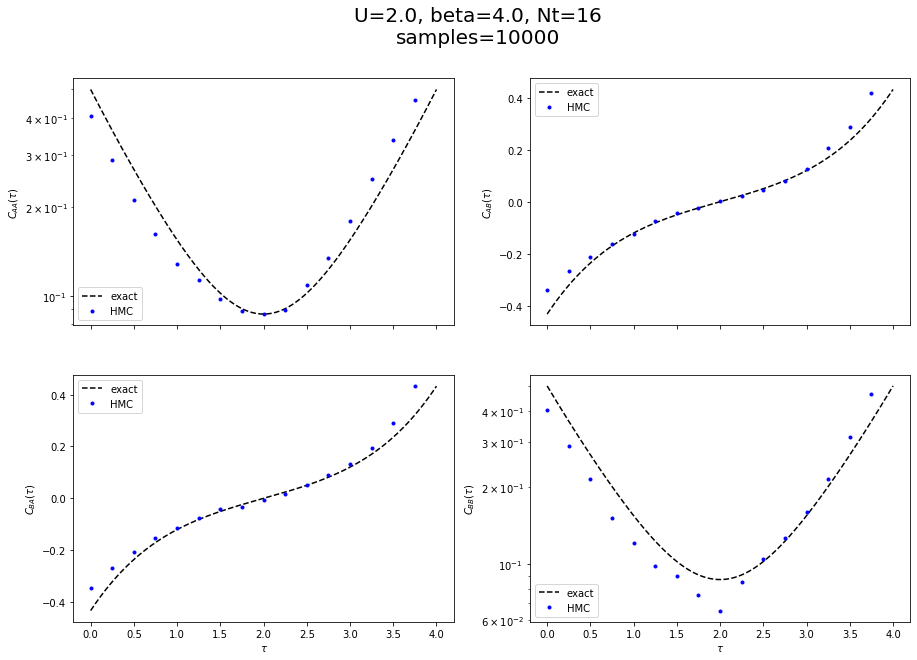

In [9]:
fig,ax = plt.subplots(2,2,figsize=(15,10),sharex=True)

aax = ax[0][0]
aax.plot(exT,exAA,'k--',label='exact')
aax.plot(tau,cAA,'b.',label='HMC')
aax.set_yscale('log')
aax.legend(loc='best')
aax.set_ylabel(r'$C_{AA}(\tau)$')

aax = ax[0][1]
aax.plot(exT,exAB,'k--',label='exact')
aax.plot(tau,cAB,'b.',label='HMC')
aax.set_ylabel(r'$C_{AB}(\tau)$')
aax.legend(loc='best')

aax = ax[1][0]
aax.plot(exT,exBA,'k--',label='exact')
aax.plot(tau,cBA,'b.',label='HMC')
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BA}(\tau)$')
aax.legend(loc='best')

aax = ax[1][1]
aax.plot(exT,exBB,'k--',label='exact')
aax.plot(tau,cBB,'b.',label='HMC')
aax.set_yscale('log')
aax.set_xlabel(r'$\tau$')
aax.set_ylabel(r'$C_{BB}(\tau)$')
aax.legend(loc='best')

plt.suptitle('U={}, beta={}, Nt={}\nsamples={}'.format(U,beta,Nt,nTrajs),fontsize=20)


In [10]:
# Generate training data from radnom sampling of normal distribution
num_samples = 10000
actual_HMC = ensemble

training_gaus = np.zeros((num_samples,Nt*Nx))
gradient_gaus = np.zeros((num_samples,Nt*Nx))

data_actual = np.array(actual_HMC)
gradient_actual = np.zeros((len(actual_HMC),Nt*Nx))

#stores data from Actual HMCdatata
xx = np.zeros((len(actual_HMC)+ num_samples,Nt*Nx))
yy= np.zeros((len(actual_HMC)+ num_samples,Nt*Nx))

for i in range(num_samples): 
    training_gaus[i,:] = np.random.normal(0,usqrt,Nt*Nx)
    gradient_gaus[i,:] = gradS(training_gaus[i,:],U*delta,Nt)
    gradient_actual[i,:] = gradS(data_actual[i,:],U*delta,Nt)
    


xx[:num_samples,:] = training_gaus[:num_samples,:]
xx[num_samples:,:] = data_actual[:,:]
yy[:num_samples,:] = gradient_gaus[:num_samples,:]
yy[num_samples:,:] = gradient_actual[:,:]

#saving the training_data
# np.save(f'inputs_2sites_U{U}B{beta}Nt{Nt}',xx)
# np.save(f'targets_2sites_U{U}B{beta}Nt{Nt}',yy)



Text(0.5, 0.98, 'U=2.0, beta=4.0, Nt=16\nsamples=20000')

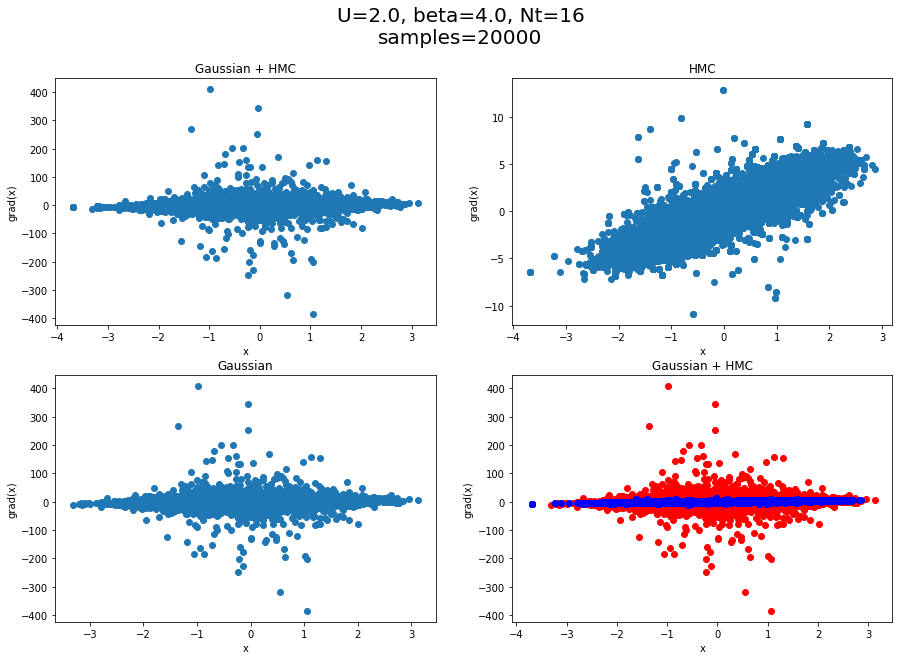

In [11]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

axx = ax[0][0]
axx.scatter(np.real(xx),np.real(yy))
axx.set_title("Gaussian + HMC")
axx.set_xlabel("x")
axx.set_ylabel("grad(x)")

axx = ax[0][1]
axx.scatter(np.real(xx[10000:]),np.real(yy[10000:]))
axx.set_title("HMC")
axx.set_xlabel("x")
axx.set_ylabel("grad(x)")

axx = ax[1][0]
axx.scatter(np.real(xx[:10000]),np.real(yy[:10000]))
axx.set_title("Gaussian")
axx.set_xlabel("x")
axx.set_ylabel("grad(x)")

axx = ax[1][1]
axx.scatter(np.real(xx[:10000]),np.real(yy[:10000]),c='r')
axx.scatter(np.real(xx[10000:]),np.real(yy[10000:]),c='b')
axx.set_title("Gaussian + HMC")
axx.set_xlabel("x")
axx.set_ylabel("grad(x)")


plt.suptitle('U={}, beta={}, Nt={}\nsamples={}'.format(U,beta,Nt,20000),fontsize=20)